In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
torch.cuda.empty_cache()
print(f"Using device: {device}")

Using device: cuda


In [2]:
def simulate_lorenz(initial_state, steps = 500, dt= 0.01, sigma = 10.0, rho = 28.0, beta = 8.0/3.0):
    def lorenz_system(state):
        x, y, z = state
        dxdt = sigma * (y - x)
        dydt = x * (rho - z) - y
        dzdt = x * y - beta * z
        return np.array([dxdt, dydt, dzdt])
    state = np.array(initial_state)
    trajectory = []
    for _ in range(steps):
        trajectory.append(state.copy())
        k1 = lorenz_system(state)
        k2 = lorenz_system(state + 0.5 * dt * k1)
        k3 = lorenz_system(state + 0.5 * dt * k2)
        k4 = lorenz_system(state + dt * k3)
        state += (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return np.array(trajectory)
        

In [3]:
def create_graph_lorenz(trajectory):
    edge_index = []
    for i in range(len(trajectory)-1):
        edge_index.append([i, i+1])
    edge_index = torch.tensor(edge_index, dtype = torch.long).t().contiguous()
    x = torch.tensor(trajectory, dtype = torch.float)

    data = Data(x=x, edge_index = edge_index)
    return data

In [4]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(output_dim)

    def create_full_graph(self, x):
        n = x.size(0)
        edge_index = torch.stack([
            torch.repeat_interleave(torch.arange(n), n),
            torch.tile(torch.arange(n), (n,))
        ]).to(x.device)
        return edge_index
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = x.float()
        edge_index = self.create_full_graph(x)
        
        # GNN path
        gnn_x = self.conv1(x, edge_index).relu()
        gnn_x = self.norm1(gnn_x)
        gnn_x = self.conv2(gnn_x, edge_index)
        gnn_x = self.norm2(gnn_x)

        # FC path - fixed the layer usage
        fc_x = self.fc1(x).relu()
        fc_x = self.fc2(fc_x).relu() 
        fc_x = self.fc3(fc_x)         

        return (gnn_x + fc_x)/2

In [5]:
class KoopmanModel(torch.nn.Module):
    def __init__(self, input_dim, koopman_dim):
        super(KoopmanModel, self).__init__()
        self.encoder = GNN(input_dim, koopman_dim, koopman_dim)
        self.koopman_matrix = torch.nn.Parameter(torch.eye(koopman_dim))
        self.decoder = GNN(koopman_dim, koopman_dim, input_dim)

    def forward(self, data):
        koopman_space = self.encoder(data)
        next_koopman_space = koopman_space @ self.koopman_matrix
        new_data = Data(x=next_koopman_space, edge_index = data.edge_index)
        new_state = self.decoder(new_data)
        return new_state

In [5]:
class KoopmanModel(torch.nn.Module):
    def __init__(self, input_dim, koopman_dim):
        super(KoopmanModel, self).__init__()
        self.encoder = GNN(input_dim, 32, koopman_dim)  # Increased hidden dimension
        # Initialize Koopman matrix as block diagonal
        init_matrix = torch.zeros(koopman_dim, koopman_dim)
        for i in range(0, koopman_dim-1, 2):
            init_matrix[i:i+2, i:i+2] = torch.tensor([[0., -1.], [1., 0.]])
        self.koopman_matrix = torch.nn.Parameter(init_matrix)
        self.decoder = GNN(koopman_dim, 32, input_dim)

    def forward(self, data):
        koopman_space = self.encoder(data)
        next_koopman_space = koopman_space @ self.koopman_matrix
        new_data = Data(x=next_koopman_space, edge_index=data.edge_index)
        return self.decoder(new_data)

In [6]:
def auto_encoding_loss(decoded, original_states):
    #return F.l1_loss(decoded, original_states)
    return F.mse_loss(decoded, original_states, reduction='mean')

def prediction_loss(model, koopman_space, data):
    T = data.x.size(0)
    all_predictions = []
    current_state = koopman_space[0].unsqueeze(0)

    for t in range(T):
        decoded_state = model.decoder(Data(x=current_state, edge_index=data.edge_index))
        all_predictions.append(decoded_state)
        if t < T - 1:
            current_state = (current_state @ model.koopman_matrix).detach().clone()
    all_predictions = torch.cat(all_predictions, dim=0)
    #return F.l1_loss(all_predictions, data.x)
    return F.mse_loss(all_predictions, data.x, reduction='mean')



def metric_loss(koopman_space, original_space):
    distances_koopman = torch.cdist(koopman_space, koopman_space, p=2)
    distances_original = torch.cdist(original_space, original_space, p=2)
    #return F.l1_loss(distances_koopman, distances_original)
    return F.mse_loss(distances_koopman, distances_original, reduction='mean')


def total_loss(model, data, lambda1=1.0, lambda2=1.0):
    koopman_space = model.encoder(data)
    decoded = model.decoder(Data(x=koopman_space, edge_index=data.edge_index))
    
    ae_loss = auto_encoding_loss(decoded, data.x)
    pred_loss = prediction_loss(model, koopman_space, data)
    m_loss = metric_loss(koopman_space, data.x)
    #print(f"AE Loss: {ae_loss}, Predicted Loss: Total Loss {m_loss}")

    return ae_loss  + lambda1 * pred_loss + lambda2 * m_loss 

In [7]:
def train_model(model, dataset, epochs = (10),lambda1=1.0, lambda2=0.3, initial_lr = 0.007):
    optimizer = Adam(model.parameters(), lr = initial_lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        verbose = True
    )
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    #     optimizer,
    #     T_0=5,
    #     T_mult=2,
    #     eta_min=1e-5
    # )
    model = model.to(device)
    train_losses = []
    #learning_rates = []
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        epoch_loss = 0
        for data in dataset:
            data = data.to(device)
            optimizer.zero_grad()
            #prediction = model(data)
            loss = total_loss(model, data,  lambda1=lambda1, lambda2=lambda2)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataset)
        scheduler.step(avg_loss)
        train_losses.append(avg_loss)
        current_lr = optimizer.param_groups[0]['lr']
        #learning_rates.append(current_lr)
        #scheduler.step()
        # if avg_loss < best_loss:
        #     best_loss = avg_loss
        print(f"Epoch {epoch + 1}, Loss {avg_loss:.4f}, LR: {current_lr:.6f}")

        #For Reduce LR
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 10: 
                print("Early stopping triggered")
                break
    plt.plot(range(epochs), train_losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.show()

In [7]:
def train_model(model, dataset, epochs=50, lambda1=1.0, lambda2=0.1):
    optimizer = Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    model = model.to(device)
    train_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        epoch_loss = 0
        for data in dataset:
            data = data.to(device)
            optimizer.zero_grad()
            loss = total_loss(model, data, lambda1=lambda1, lambda2=lambda2)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Added gradient clipping
            optimizer.step()
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(dataset)
        scheduler.step(avg_loss)
        train_losses.append(avg_loss)
        
        print(f"Epoch {epoch + 1}, Loss {avg_loss:.4f}")
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 15:
                print("Early stopping triggered")
                break
                
    return train_losses


In [15]:
def normalize_lorenz_trajectory(trajectory):
    # Dynamic normalization using actual ranges
    min_vals = np.min(trajectory, axis=0)
    max_vals = np.max(trajectory, axis=0)
    range_vals = max_vals - min_vals
    normalized = (trajectory - min_vals) / range_vals
    return normalized, min_vals, range_vals

def denormalize_lorenz_trajectory(normalized_trajectory, min_vals, range_vals):
    return normalized_trajectory * range_vals + min_vals

In [17]:
dataset = []
for _ in range(200): 
    initial_state = [
        np.random.normal(1.0, 0.2),
        np.random.normal(0.0, 0.2),
        np.random.normal(0.0, 0.2)
    ]
    trajectory = simulate_lorenz(initial_state)
    normalized_trajectory, min_vals, range_vals = normalize_lorenz_trajectory(trajectory)
    data = create_graph_lorenz(normalized_trajectory)
    data.min_vals = min_vals
    data.range_vals = range_vals
    dataset.append(data)

In [109]:
model = KoopmanModel(input_dim = 3, koopman_dim = 6).to(device)

In [111]:
losses = train_model(model, dataset, epochs=100)

Epoch 1, Loss 0.1123
Epoch 2, Loss 0.0477
Epoch 3, Loss 0.0437
Epoch 4, Loss 0.0406
Epoch 5, Loss 0.0397
Epoch 6, Loss 0.0400
Epoch 7, Loss 0.0372
Epoch 8, Loss 0.0374
Epoch 9, Loss 0.0381
Epoch 10, Loss 0.0378
Epoch 11, Loss 0.0419
Epoch 12, Loss 0.0398
Epoch 13, Loss 0.0388
Epoch 14, Loss 0.0359
Epoch 15, Loss 0.0347
Epoch 16, Loss 0.0333
Epoch 17, Loss 0.0328
Epoch 18, Loss 0.0326
Epoch 19, Loss 0.0320
Epoch 20, Loss 0.0321
Epoch 21, Loss 0.0309
Epoch 22, Loss 0.0317
Epoch 23, Loss 0.0315
Epoch 24, Loss 0.0310
Epoch 25, Loss 0.0314
Epoch 26, Loss 0.0306
Epoch 27, Loss 0.0312
Epoch 28, Loss 0.0320
Epoch 29, Loss 0.0313
Epoch 30, Loss 0.0316
Epoch 31, Loss 0.0325
Epoch 32, Loss 0.0319
Epoch 33, Loss 0.0297
Epoch 34, Loss 0.0297
Epoch 35, Loss 0.0299
Epoch 36, Loss 0.0301
Epoch 37, Loss 0.0300
Epoch 38, Loss 0.0300
Epoch 39, Loss 0.0298
Epoch 40, Loss 0.0296
Epoch 41, Loss 0.0296
Epoch 42, Loss 0.0297
Epoch 43, Loss 0.0296
Epoch 44, Loss 0.0296
Epoch 45, Loss 0.0296
Epoch 46, Loss 0.02

Epoch 1, Loss 0.1034, LR: 0.007000
Epoch 2, Loss 0.0830, LR: 0.007000
Epoch 3, Loss 0.0799, LR: 0.007000
Epoch 4, Loss 0.0905, LR: 0.007000
Epoch 5, Loss 0.0904, LR: 0.007000
Epoch 6, Loss 0.0877, LR: 0.003500
Epoch 7, Loss 0.0815, LR: 0.003500
Epoch 8, Loss 0.0847, LR: 0.003500
Epoch 9, Loss 0.0861, LR: 0.001750
Epoch 10, Loss 0.0849, LR: 0.001750


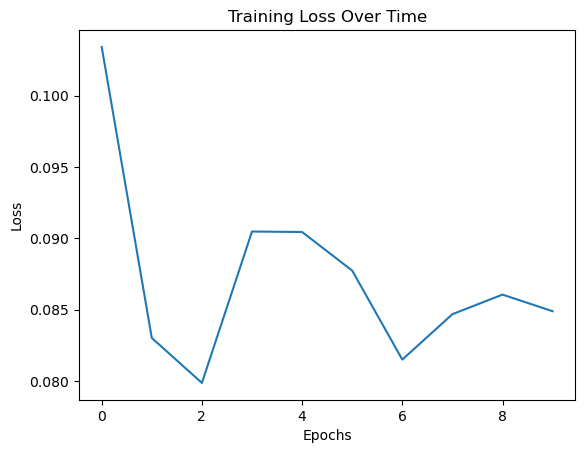

In [147]:
train_model(model, dataset, epochs = 10)

In [19]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [21]:
save_folder = "lorenz-koopman-models"
os.makedirs(save_folder, exist_ok = True)

In [23]:
save_path = os.path.join(save_folder, "lorenz-koopman-model-2.2.pth")

In [115]:

torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")

Model saved to lorenz-koopman-models\lorenz-koopman-model-2.2.pth


In [25]:
model = KoopmanModel(input_dim=3, koopman_dim=6).to(device)
model.load_state_dict(torch.load(save_path, weights_only=True))
model.eval()

KoopmanModel(
  (encoder): GNN(
    (fc1): Linear(in_features=3, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=6, bias=True)
    (conv1): GCNConv(3, 32)
    (conv2): GCNConv(32, 6)
    (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): GNN(
    (fc1): Linear(in_features=6, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=3, bias=True)
    (conv1): GCNConv(6, 32)
    (conv2): GCNConv(32, 3)
    (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
  )
)

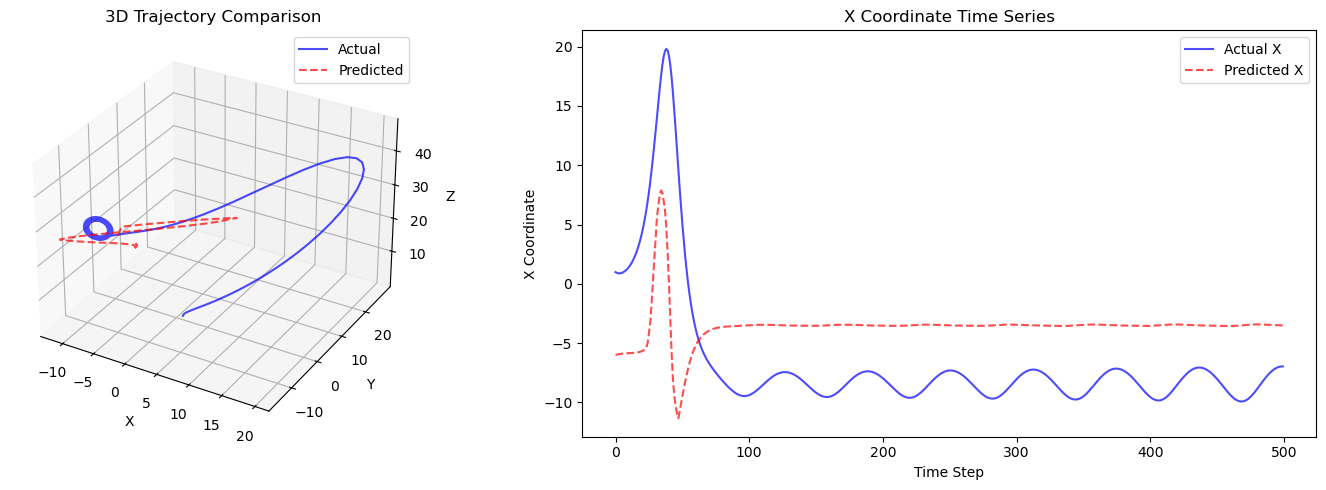

Actual trajectory range: [ -9.9161777  -10.57421252   0.02656491] [19.81805933 27.60608472 48.2660624 ]
Predicted trajectory range: [-11.33006881 -15.4016367   22.66428725] [ 7.88438217  4.17840568 30.43139617]


In [29]:
# Load the model
# model = KoopmanModel(input_dim=3, koopman_dim=6).to(device)
# model.load_state_dict(torch.load("lorenz-koopman-models/lorenz-koopman-model-2.0.pth"))
# model.eval()

# Use the first trajectory from your dataset as an example
test_data = dataset[145].to(device)  # Get the first trajectory from your dataset

# Get predictions
with torch.no_grad():
    predicted = model(test_data).cpu().numpy()

# Get the actual trajectory (denormalize the input data)
actual_trajectory = denormalize_lorenz_trajectory(
    test_data.x.cpu().numpy(), 
    test_data.min_vals, 
    test_data.range_vals
)

# Denormalize the predicted trajectory
predicted_trajectory = denormalize_lorenz_trajectory(
    predicted, 
    test_data.min_vals, 
    test_data.range_vals
)

# Create the visualization
fig = plt.figure(figsize=(15, 5))

# 3D trajectory plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(actual_trajectory[:, 0], actual_trajectory[:, 1], actual_trajectory[:, 2], 
         'b-', label='Actual', alpha=0.7)
ax1.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], predicted_trajectory[:, 2], 
         'r--', label='Predicted', alpha=0.7)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D Trajectory Comparison')
ax1.legend()

# Time series plot
ax2 = fig.add_subplot(122)
time = np.arange(len(actual_trajectory))
ax2.plot(time, actual_trajectory[:, 0], 'b-', label='Actual X', alpha=0.7)
ax2.plot(time, predicted_trajectory[:, 0], 'r--', label='Predicted X', alpha=0.7)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('X Coordinate')
ax2.set_title('X Coordinate Time Series')
ax2.legend()

plt.tight_layout()
plt.show()

# Print some statistics to verify the predictions
print("Actual trajectory range:", 
      np.min(actual_trajectory, axis=0), 
      np.max(actual_trajectory, axis=0))
print("Predicted trajectory range:", 
      np.min(predicted_trajectory, axis=0), 
      np.max(predicted_trajectory, axis=0))